In [1]:
import torch
import torch.nn as nn

import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import re
from sklearn.model_selection import train_test_split

%matplotlib inline

In [ ]:
import os
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
noisy_dir = "C:/Users/user/Desktop/Spectrum Sensing/random_SNR_CNN"

# 키 생성 함수
def natural_key(filename):
    return [int(text) if text.isdigit() else text.lower() for text in re.split(r'(\d+)', filename)]
# 이미지 불러오기 및 전처리 함수 정의
def load_images_from_directory(directory):
    images = []
    for filename in sorted(os.listdir(directory), key=natural_key):
        img_path = os.path.join(directory, filename)
        img = Image.open(img_path).convert("L") #이미지 불러오기 & 흑백 변환
        img = np.array(img, dtype=np.float32) / 255.0  # 정규화
        images.append(img)
    return np.stack(images, axis=0)  

noisy_images = load_images_from_directory(noisy_dir) 

# 데이터 확인
print(f"Noisy Images Shape: {noisy_images.shape}")

Noisy Images Shape: (20000, 256, 256)


In [3]:
o, z = 10000, 10000
ones = np.ones(o)
zeros = np.zeros(z)
label = np.concatenate([ones, zeros], axis=0)

In [4]:
label.shape

(20000,)

In [ ]:
bat_size = 50

X_train_np, X_val_np, y_train_np, y_val_np = train_test_split(noisy_images, label, test_size=0.2, random_state=0)
X_val_np, X_test_np, y_val_np, y_test_np = train_test_split(X_val_np, y_val_np, test_size=0.5, random_state=0)

X_train = torch.tensor(X_train_np, dtype=torch.float32).unsqueeze(1).to(device)
y_train = torch.tensor(y_train_np, dtype=torch.long).to(device)
X_val = torch.tensor(X_val_np, dtype=torch.float32).unsqueeze(1).to(device)
y_val = torch.tensor(y_val_np, dtype=torch.long).to(device)
X_test = torch.tensor(X_test_np, dtype=torch.float32).unsqueeze(1).to(device)
y_test = torch.tensor(y_test_np, dtype=torch.long).to(device)

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(dataset=train_dataset, batch_size=bat_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=bat_size, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=bat_size, shuffle=False)

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

torch.Size([16000, 1, 256, 256]) torch.Size([16000]) torch.Size([2000, 1, 256, 256]) torch.Size([2000])


In [8]:
class SpectrogramDenoisingAutoencoder(nn.Module):
    def __init__(self):
        super(SpectrogramDenoisingAutoencoder, self).__init__() 
        self.outoconder = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=3, stride=2, padding=1), nn.ReLU(),
            nn.ConvTranspose2d(4, 1, kernel_size=3, stride=2, padding=1, output_padding=1), nn.Sigmoid()
        )
        self.outoconder2 = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=3, stride=2, padding=1), nn.ReLU(),
            nn.ConvTranspose2d(4, 1, kernel_size=3, stride=2, padding=1, output_padding=1), nn.Sigmoid()
        )
        self.outoconder3 = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=3, stride=2, padding=1), nn.ReLU(),
            nn.ConvTranspose2d(4, 1, kernel_size=3, stride=2, padding=1, output_padding=1), nn.Sigmoid()
        )
        self.outoconder4 = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=3, stride=2, padding=1), nn.ReLU(),
            nn.ConvTranspose2d(4, 1, kernel_size=3, stride=2, padding=1, output_padding=1), nn.Sigmoid()
        )
        self.outoconder11 = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=3, stride=2, padding=1), nn.ReLU(),
            nn.ConvTranspose2d(4, 1, kernel_size=3, stride=2, padding=1, output_padding=1), nn.Sigmoid()
        )
    
    def forward(self, x):
        outo1 = self.outoconder(x)
        outo2 = (self.outoconder2(outo1) + outo1)/2
        outo3 = self.outoconder3(outo2)
        outo4 = (self.outoconder4(outo3) + outo3)/2
        last = self.outoconder11(outo4)
        return x, outo3, last
    
class CNN(nn.Module):
    def __init__(self, k = 1):
        super(CNN, self).__init__()
        self.k = k
        self.start = nn.Sequential(
            nn.Conv2d(3, 8*self.k, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(8*self.k), nn.ReLU()
        )
        self.start2 = nn.Sequential(
            nn.Conv2d(8*self.k, 16*self.k, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(16*self.k), nn.ReLU(),
            nn.Conv2d(16*self.k, 32*self.k, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32*self.k), nn.ReLU()
        )
        self.conv1 = nn.Sequential(
            nn.Conv2d(32*self.k, 32*self.k, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32*self.k), nn.ReLU(),
            nn.Conv2d(32*self.k, 64*self.k, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64*self.k), nn.ReLU(),
            nn.Conv2d(64*self.k, 64*self.k, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64*self.k), nn.ReLU()    
        )
        
        self.pool = nn.AvgPool2d(kernel_size=32)
        self.fc = nn.Sequential(nn.Linear(64*self.k, 2), nn.Sigmoid())    

    def forward(self, x):
        x = self.start(x)
        x = self.start2(x)
        x = self.conv1(x)
        
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [24]:
Autoencoder = SpectrogramDenoisingAutoencoder()
model_path = f"C:/Users/user/Desktop/위/SpectrogramDenoisingAutoencoder_50.pth"

# 모델 가중치 로드
Autoencoder.load_state_dict(torch.load(model_path))
Autoencoder.to('cpu')

SpectrogramDenoisingAutoencoder(
  (outoconder): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(4, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): Sigmoid()
  )
  (outoconder2): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(4, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): Sigmoid()
  )
  (outoconder3): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(4, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): Sigmoid()
  )
  (outoconder4): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(4, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3)

In [10]:
output_list = []
label_list = []
Autoencoder.eval()
for inputs, targets in train_loader:
    out1, out2, out3 = Autoencoder(inputs.to('cpu'))
    out = torch.cat((out1, out2, out3), dim=1).detach()
    output_list.append(out)
    label_list.append(targets)
for inputs, targets in val_loader:
    out1, out2, out3 = Autoencoder(inputs.to('cpu'))
    out = torch.cat((out1, out2, out3), dim=1).detach()
    output_list.append(out)
    label_list.append(targets)
for inputs, targets in test_loader:
    out1, out2, out3 = Autoencoder(inputs.to('cpu'))
    out = torch.cat((out1, out2, out3), dim=1).detach()
    output_list.append(out)
    label_list.append(targets)
outputs = torch.cat(output_list, dim=0)
targetss = torch.cat(label_list, dim=0)

In [11]:
train_len = len(train_loader.dataset)
val_len = len(val_loader.dataset)
test_len = len(test_loader.dataset)

X_train_auto = outputs[:train_len].to(device)
X_val_auto = outputs[train_len : train_len+val_len].to(device)
X_test_auto = outputs[train_len+val_len : train_len+val_len+test_len].to(device)
y_train_auto = targetss[:train_len].to(device)
y_val_auto = targetss[train_len : train_len+val_len].to(device)
y_test_auto = targetss[train_len+val_len : train_len+val_len+test_len].to(device)

In [ ]:
# 데이터셋과 데이터로더 생성
train_dataset_auto = TensorDataset(X_train_auto, y_train_auto)
val_dataset_auto = TensorDataset(X_val_auto, y_val_auto)
test_dataset_auto = TensorDataset(X_test_auto, y_test_auto)
train_loader_auto = DataLoader(dataset=train_dataset_auto, batch_size=bat_size, shuffle=True)
val_loader_auto = DataLoader(dataset=val_dataset_auto, batch_size=bat_size, shuffle=False)
test_loader_auto = DataLoader(dataset=test_dataset_auto, batch_size=bat_size, shuffle=False)

In [ ]:
del Autoencoder
torch.cuda.empty_cache()  # GPU 메모리

In [14]:
device

device(type='cuda')

In [ ]:
import torch.nn.functional as F

class WeightedFocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2, reduction='mean'):
        super(WeightedFocalLoss, self).__init__()
        self.alpha = torch.tensor(alpha) if alpha is not None else None
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        probs = F.softmax(inputs, dim=1)
        targets_one_hot = F.one_hot(targets, num_classes=inputs.size(1)).float()

        # Cross-Entropy Loss
        ce_loss = -targets_one_hot * torch.log(probs)
        
        # Focal Loss: (1 - pt)^gamma * CE
        focal_loss = (1 - probs) ** self.gamma * ce_loss
        
         # alpha setting
        if self.alpha is not None:
            alpha_tensor = self.alpha.to(inputs.device)  # alpha를 GPU로 이동
            focal_loss = focal_loss * alpha_tensor.unsqueeze(0)
        
        # 축소 선택
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

from ranger import Ranger
model = CNN(k=2).to(device)
criterion = WeightedFocalLoss(alpha=None, gamma=1.5).to(device)
optimizer = Ranger(model.parameters(), lr=0.01) # optim.Adam(model.parameters(), lr=0.001)

total_params = count_parameters(model)
print(f"Total number of parameters: {total_params}")

Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers
Total number of parameters: 282690


In [ ]:
patience = 10
num_epochs = 4000
best_val_loss = float('inf')
patience_counter = 0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for inputs, targets in train_loader_auto:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs).to(device)
        loss = criterion(outputs, targets).to(device)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)  # 배치 크기 고려
    train_loss = train_loss / len(train_loader.dataset)
    
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader_auto:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs).to(device)
            loss = criterion(outputs, targets).to(device)
            val_loss += loss.item() * inputs.size(0)
    val_loss = val_loss / len(val_loader.dataset)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        checkpoint = {
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': best_val_loss,
            'epoch': epoch
        }
        torch.save(checkpoint, 'checkpoint/best_model.pth')
        print(f'Checkpoint saved at epoch {epoch+1} with validation loss: {10*best_val_loss:.4f} // Training Loss: {10*train_loss:.4f}')
        patience_counter = 0  # patience counter를 리셋합니다.
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break
        

# 체크포인트 불러오기
checkpoint = torch.load('checkpoint/best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
best_val_loss = checkpoint['loss']

print(f'Model loaded from checkpoint with loss: {best_val_loss:.7f} at epoch: {epoch+1}')

c:\Users\user\anaconda3\envs\new\lib\site-packages\ranger\ranger.py:138: UserWarning: This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value) (Triggered internally at  ..\torch\csrc\utils\python_arg_parser.cpp:1025.)
  exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)


Checkpoint saved at epoch 1 with validation loss: 0.6278 // Training Loss: 0.6754
Checkpoint saved at epoch 2 with validation loss: 0.5587 // Training Loss: 0.5754
Checkpoint saved at epoch 3 with validation loss: 0.5183 // Training Loss: 0.5424
Checkpoint saved at epoch 5 with validation loss: 0.5084 // Training Loss: 0.5131
Checkpoint saved at epoch 6 with validation loss: 0.4916 // Training Loss: 0.4876
Checkpoint saved at epoch 7 with validation loss: 0.4761 // Training Loss: 0.4806
Checkpoint saved at epoch 8 with validation loss: 0.4756 // Training Loss: 0.4649
Checkpoint saved at epoch 10 with validation loss: 0.4740 // Training Loss: 0.4442
Early stopping at epoch 20
set state called
Model loaded from checkpoint with loss: 0.0473954 at epoch: 10


In [ ]:
from sklearn.metrics import accuracy_score, recall_score

def evaluate_model(model, data_loader):
    all_preds = []  
    all_targets = []  
    model.eval()  
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)

            if outputs.size(1) > 1:  
                preds = torch.argmax(outputs, dim=1)
            else:  
                preds = (torch.sigmoid(outputs) > 0.5).long()

            all_preds.append(preds.cpu())
            all_targets.append(targets.cpu())

    all_preds = torch.cat(all_preds).numpy()
    all_targets = torch.cat(all_targets).numpy()

    accuracy = accuracy_score(all_targets, all_preds)
    recall = recall_score(all_targets, all_preds, pos_label=1) 

    return accuracy, recall

accuracy, recall = evaluate_model(model, test_loader_auto)
print(f"Accuracy: {accuracy:.4f}, Recall: {recall:.4f}")

Accuracy: 0.9275, Recall: 0.8632


In [23]:
PATH = f'./FocalLoss_CNN_{bat_size}_k=2.pth'
torch.save(model.state_dict(), PATH)

tensor([4.5982e-08, 1.0000e+00], grad_fn=<SelectBackward>)


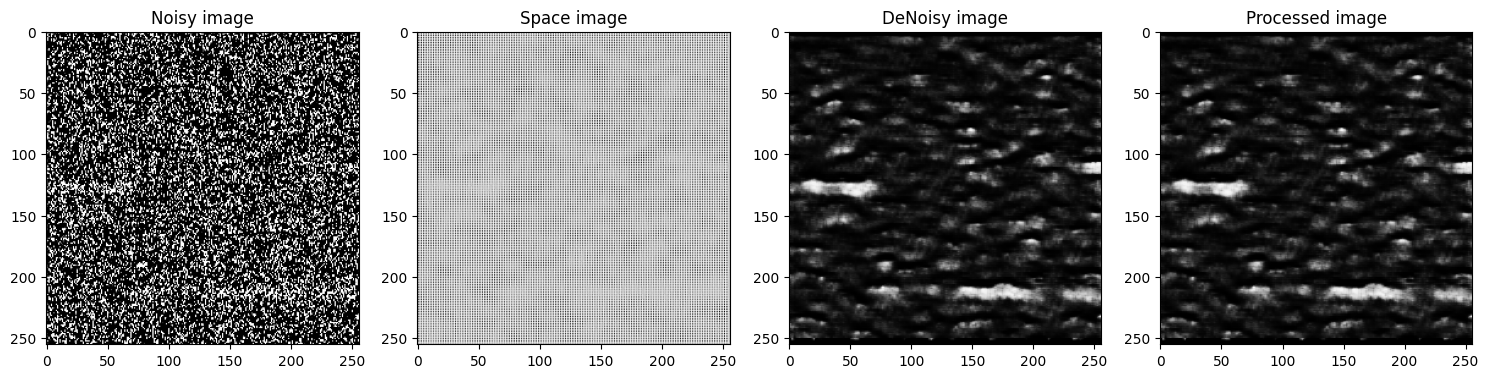

In [ ]:
index = 9
Autoencoder.eval()
Autoencoder = Autoencoder.cpu()  

for inputs, targets in test_loader:
    out1, out2, out3 = Autoencoder(inputs.to('cpu'))
    out = torch.cat((out1, out2, out3), dim=1).to('cpu')  
    break

model.eval()
model = model.cpu()  
w = model(out)  

fig, axes = plt.subplots(1, 4, figsize=(15, 5))
axes[0].imshow(out1[index].detach().numpy().reshape(256, 256), cmap="gray")
axes[0].set_title("Noisy image")

axes[1].imshow(out2[index].detach().numpy().reshape(256, 256), cmap="gray")
axes[1].set_title("Space image")

axes[2].imshow(out3[index].detach().numpy().reshape(256, 256), cmap="gray")
axes[2].set_title("DeNoisy image")

axes[3].imshow(out3[index].detach().numpy().reshape(256, 256), cmap="gray")
axes[3].set_title("Processed image")

print(w[index])  # 예측값 출력
plt.tight_layout()
plt.show()